# 4_hts_preparation
* start by making a separate univariate dataset of energy readings for each meter in each cluster
* of dimensions [num_meters, num_timesteps]

* will then use hts to make predictions on that
* then will use the other features to adjust them

# imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from datetime import datetime

In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf

# pd display options

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# loading the data

In [3]:
df_energy = pd.read_pickle("../../Data/Preprocessed_Data/consumption_clustered.pkl")
df_energy

,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-14,2017-01-15,2017-01-16,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-21,2017-01-22,2017-01-23,2017-01-24,...,2017-12-08,2017-12-09,2017-12-10,2017-12-11,2017-12-12,2017-12-13,2017-12-14,2017-12-15,2017-12-16,2017-12-17,2017-12-18,2017-12-19,2017-12-20,2017-12-21,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31,labels
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.7410,5.48250,7.224,4.951,4.19650,3.4420,3.509,4.6750,6.131,4.962,3.336,4.318,3.561,4.279,4.030,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395,5
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.4690,24.09950,24.730,24.597,22.32650,20.0560,22.546,22.3330,23.353,22.774,20.229,21.218,15.419,13.475,13.101,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751,3
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0265,16.22475,12.423,18.379,15.85025,13.3215,13.821,14.2175,16.712,12.364,16.102,18.601,10.385,10.917,10.201,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633,1
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.3150,21.49350,19.672,21.023,20.35450,19.6860,23.435,18.7330,22.249,20.755,19.730,21.135,16.526,12.677,14.833,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452,3
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.3880,41.99750,48.607,54.760,48.73150,42.7030,35.045,38.6640,36.790,29.009,42.716,29.052,25.444,28.234,39.440,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,2.317,2.301,2.352,2.516,2.229,2.354,2.397,2.397,2.269,2.3040,2.339,2.212,2.456,2.229,2.503,2.207,2.469,2.266,2.321,2.262,2.286,2.384,2.319,2.289,...,9.9760,10.30550,10.635,10.650,10.39950,10.1490,10.112,10.6320,10.566,10.732,10.615,10.386,9.936,9.625,9.390,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480,1
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,14.437,16.274,7.031,17.018,17.603,15.005,8.987,8.490,10.136,10.3010,10.466,8.177,11.929,8.261,12.369,14.352,14.058,10.472,17.396,9.879,21.971,12.708,15.327,8.309,...,5.8620,6.81600,7.770,5.091,5.60000,6.1090,5.056,3.9720,3.458,7.793,9.837,8.697,5.079,6.031,4.141,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401,5
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,7.824,7.517,5.398,6.788,7.360,6.898,7.321,8.042,8.207,6.8355,5.464,7.545,6.432,6.001,5.558,6.391,6.066,6.443,6.675,7.363,7.269,7.183,7.102,6.449,...,7.2410,6.46800,5.695,8.143,7.56800,6.9930,6.451,7.6290,6.880,5.960,6.231,5.748,5.259,5.258,6.767,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148,5
3246,0x47218b46abb2fcaade487a211911406dc6e13730,23.965,28.689,27.664,29.229,29.548,27.909,26.923,21.277,23.452,24.6880,25.924,26.834,30.346,30.367,26.135,26.842,25.588,30.267,28.921,27.530,28.424,28.961,29.346,28.640,...,28.7260,29.28500,29.844,31.899,30.96900,30.0390,30.470,30.0440,28.617,31.578,31.481,32.123,29.524,22.586,20.747,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201,0


# making a separate dataframe for each cluster

In [4]:
# splitting by labels
df_clusters = {k: v for (k, v) in df_energy.groupby('labels')}

In [5]:
# saving these clusters to pickle
for i in range(len(df_clusters)):
    df_clusters[i] = df_clusters[i].drop("labels",axis=1)
    print(f"cluster {i} lenth: {len(df_clusters[i])}")
    df_clusters[i].to_pickle(f"../../Data/Prepared_Data/consumption_cluster_{i}.pkl")

cluster 0 lenth: 254
cluster 1 lenth: 1093
cluster 2 lenth: 21
cluster 3 lenth: 569
cluster 4 lenth: 80
cluster 5 lenth: 1231


# preparing for hts
* Just univariate time series (no addInfo)
* Separate column for each meter id
* Time goes along the row

In [6]:
print(df_clusters[2].columns)

Index(['meter_id', '2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
       '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09',
       ...
       '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-26',
       '2017-12-27', '2017-12-28', '2017-12-29', '2017-12-30', '2017-12-31'],
      dtype='object', length=366)


In [7]:
df_hts_clusters=df_clusters.copy()

# preparing each cluster for hts
for i in range(len(df_hts_clusters)):
    # printing how many nans exist 
    print(f"meters with nans in cluster {i} before = {len(df_hts_clusters[i].T.columns[df_hts_clusters[i].T.isna().any()].tolist())}")
    
    # printing Shape
    print(f"shape of cluster {i} before = {df_hts_clusters[i].shape}") 
    
    # Drop all na
    #df_hts_clusters[i]=df_hts_clusters[i].dropna(axis=1)
    
    # Get the last X days
    X = 29
    df_hts_clusters[i]=pd.concat([pd.DataFrame(df_hts_clusters[i]["meter_id"]),df_hts_clusters[i].iloc[:,-X:]], axis=1)
    
    # printing how many nans exist 
    print(f"meters with nans in cluster {i} after = {len(df_hts_clusters[i].T.columns[df_hts_clusters[i].T.isna().any()].tolist())}")
    
    # printing Shape
    print(f"shape of cluster {i} after = {df_hts_clusters[i].shape}") 
    
    #date colulmn name
    df_hts_clusters[i]=df_hts_clusters[i].rename(columns={"meter_id":"Date"})
    
    #Transposing
    df_hts_clusters[i]=df_hts_clusters[i].T
    
    #Resetting the index
    df_hts_clusters[i]=df_hts_clusters[i].reset_index()
    
    #date colulmn name
    df_hts_clusters[i]=df_hts_clusters[i].rename(columns={"meter_id":"Date"})
    
    #Making the meter_id's the headers
    new_header = df_hts_clusters[i].iloc[0] #grab the first row for the header
    df_hts_clusters[i] = df_hts_clusters[i][1:] #take the data less the header row
    df_hts_clusters[i].columns = new_header #set the header row as the df header

    print()
    print()
    
df_hts_clusters[2]

meters with nans in cluster 0 before = 236
shape of cluster 0 before = (254, 366)
meters with nans in cluster 0 after = 0
shape of cluster 0 after = (254, 30)


meters with nans in cluster 1 before = 999
shape of cluster 1 before = (1093, 366)
meters with nans in cluster 1 after = 0
shape of cluster 1 after = (1093, 30)


meters with nans in cluster 2 before = 21
shape of cluster 2 before = (21, 366)
meters with nans in cluster 2 after = 0
shape of cluster 2 after = (21, 30)


meters with nans in cluster 3 before = 527
shape of cluster 3 before = (569, 366)
meters with nans in cluster 3 after = 0
shape of cluster 3 after = (569, 30)


meters with nans in cluster 4 before = 71
shape of cluster 4 before = (80, 366)
meters with nans in cluster 4 after = 1
shape of cluster 4 after = (80, 30)


meters with nans in cluster 5 before = 1129
shape of cluster 5 before = (1231, 366)
meters with nans in cluster 5 after = 15
shape of cluster 5 after = (1231, 30)




,Date,0xfdba3ac7bea02452616ba020127c27992ef7db9f,0x369bb5e5c60d94341e4543cd031ad077c4fe0813,0x01794377dd73839621a335c47fbfe092437199fb,0x2173bea37c85ff873afe8d5609f02028b5496361,0xaa3f179a56d0e04600e1a3de90d3bd7ca0c45508,0xf6e94f4f524a383c7cb7b8a4c7518fbf2ffd9e60,0x2949aafcd2efa12be7fbd8bdfa948c34a972ed1f,0xb6c7d5b1b43d05f816c7ba7e8f308ad58f93b8e1,0x968122de3f1904f78931dd84a43abee72b5e4fde,0xaaae6c209fcacd85225f22f86a437999dd256b60,0xad7d39312dc23f26b760a8cecbb62c4165e45f5d,0x95fc7e54336e87feed25423b86d9ea92e47432dc,0xd4f466b4dd0cff2bdec56816b5e8b78309d8a525,0xd0f52ce4a47343719fd562bf1d21baa37c293960,0x1d1cd035b25dc765ba1ea8bedc6bb67e2e025c10,0xb6a976e19e18eb5017c52f2ed9457eb503ee13a6,0xb1907f64a879314c298b0f560566234e0e62f8cf,0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34,0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8,0xe02729680daab38f03461a594ec341c9cb61904f,0x43d6497a2cc16fa61d18c393f697352bb4b41964
1,2017-12-03,67.043,71.635,94.226,56.715,69.792,23.901,52.996,84.171,84.343,69.052,52.044,74.6537,63.705,45.3883,66.519,70.01,73.972,44.356,41.261,71.921,76.156
2,2017-12-04,65.723,6.084,89.364,60.979,64.094,34.066,101.291,94.169,72.439,69.986,47.674,75.4199,58.518,46.1845,62.243,67.088,52.93,53.3465,54.795,63.851,81.482
3,2017-12-05,65.011,6.773,84.2285,59.933,67.324,27.8425,89.659,88.907,71.554,67.59,45.436,76.186,52.215,57.5015,57.7835,66.873,54.179,53.3762,68.0765,65.3755,76.8487
4,2017-12-06,64.299,7.462,79.093,58.887,70.554,21.619,78.027,83.645,70.669,65.194,43.198,76.9522,45.912,63.5845,53.324,66.658,55.428,53.406,81.358,66.9,72.2155
5,2017-12-07,69.839,7.038,74.546,63.843,65.854,29.845,88.084,86.07,69.775,64.732,49.808,77.7183,46.351,66.45,58.917,64.606,55.764,47.256,98.361,67.188,67.652
6,2017-12-08,67.6,8.879,109.929,58.453,92.896,33.73,113.534,86.069,81.988,66.872,69.345,78.4845,69.171,71.6115,65.446,73.57,79.583,69.836,142.88,79.188,70.896
7,2017-12-09,77.5025,8.2615,95.0955,59.8295,91.771,81.413,120.992,87.196,83.8065,71.6525,77.464,79.2507,72.436,70.132,67.702,73.806,83.7385,83.8725,134.62,82.2545,75.025
8,2017-12-10,87.405,7.644,80.262,61.206,90.646,129.096,128.45,88.323,85.625,76.433,85.583,80.0168,75.701,56.5945,69.958,74.042,87.894,97.909,126.361,85.321,79.154
9,2017-12-11,73.089,6.027,119.279,69.384,86.196,111,125.41,105.167,89.685,79.009,83.265,80.783,82.622,57.564,78.242,86.835,87.581,88.983,119.753,80.385,72.551
10,2017-12-12,73.484,5.9075,107.369,64.091,73.508,111.132,104.865,94.4555,85.029,78.241,79.182,66.1745,81.771,61.263,76.308,85.076,80.01,74.757,84.811,78.7565,73.701


# TODO :
* find a way to deal with the missing values
* experiment with different values of X (number of days)

* remember after saving go into the .txt and change "meter_id" to "date" and remove first row

# experimenting with pyaf

Based off of methodology shown here: https://notebook.community/antoinecarme/pyaf/docs/PyAF_Hierarchical_FrenchWineExportation

Important links:
https://pypi.org/project/pyaf/
https://notebook.community/antoinecarme/pyaf/docs/PyAF_Hierarchical_FrenchWineExportation
https://otexts.com/fpp2/hierarchical.html
https://github.com/antoinecarme/pyaf
https://stats.stackexchange.com/questions/412276/how-to-handle-many-times-series-simultaneously


In [8]:
# for now just going to drop all meters which have missing values
# and just going to use cluster 2 as it only has 20 meters so it will be easier to experiment with in R
df = df_hts_clusters[2]#.dropna(axis=1)

df.to_csv(f"../../Data/Prepared_Data/hts_cluster_{2}_experiment.csv")

In [9]:
df

,Date,0xfdba3ac7bea02452616ba020127c27992ef7db9f,0x369bb5e5c60d94341e4543cd031ad077c4fe0813,0x01794377dd73839621a335c47fbfe092437199fb,0x2173bea37c85ff873afe8d5609f02028b5496361,0xaa3f179a56d0e04600e1a3de90d3bd7ca0c45508,0xf6e94f4f524a383c7cb7b8a4c7518fbf2ffd9e60,0x2949aafcd2efa12be7fbd8bdfa948c34a972ed1f,0xb6c7d5b1b43d05f816c7ba7e8f308ad58f93b8e1,0x968122de3f1904f78931dd84a43abee72b5e4fde,0xaaae6c209fcacd85225f22f86a437999dd256b60,0xad7d39312dc23f26b760a8cecbb62c4165e45f5d,0x95fc7e54336e87feed25423b86d9ea92e47432dc,0xd4f466b4dd0cff2bdec56816b5e8b78309d8a525,0xd0f52ce4a47343719fd562bf1d21baa37c293960,0x1d1cd035b25dc765ba1ea8bedc6bb67e2e025c10,0xb6a976e19e18eb5017c52f2ed9457eb503ee13a6,0xb1907f64a879314c298b0f560566234e0e62f8cf,0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34,0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8,0xe02729680daab38f03461a594ec341c9cb61904f,0x43d6497a2cc16fa61d18c393f697352bb4b41964
1,2017-12-03,67.043,71.635,94.226,56.715,69.792,23.901,52.996,84.171,84.343,69.052,52.044,74.6537,63.705,45.3883,66.519,70.01,73.972,44.356,41.261,71.921,76.156
2,2017-12-04,65.723,6.084,89.364,60.979,64.094,34.066,101.291,94.169,72.439,69.986,47.674,75.4199,58.518,46.1845,62.243,67.088,52.93,53.3465,54.795,63.851,81.482
3,2017-12-05,65.011,6.773,84.2285,59.933,67.324,27.8425,89.659,88.907,71.554,67.59,45.436,76.186,52.215,57.5015,57.7835,66.873,54.179,53.3762,68.0765,65.3755,76.8487
4,2017-12-06,64.299,7.462,79.093,58.887,70.554,21.619,78.027,83.645,70.669,65.194,43.198,76.9522,45.912,63.5845,53.324,66.658,55.428,53.406,81.358,66.9,72.2155
5,2017-12-07,69.839,7.038,74.546,63.843,65.854,29.845,88.084,86.07,69.775,64.732,49.808,77.7183,46.351,66.45,58.917,64.606,55.764,47.256,98.361,67.188,67.652
6,2017-12-08,67.6,8.879,109.929,58.453,92.896,33.73,113.534,86.069,81.988,66.872,69.345,78.4845,69.171,71.6115,65.446,73.57,79.583,69.836,142.88,79.188,70.896
7,2017-12-09,77.5025,8.2615,95.0955,59.8295,91.771,81.413,120.992,87.196,83.8065,71.6525,77.464,79.2507,72.436,70.132,67.702,73.806,83.7385,83.8725,134.62,82.2545,75.025
8,2017-12-10,87.405,7.644,80.262,61.206,90.646,129.096,128.45,88.323,85.625,76.433,85.583,80.0168,75.701,56.5945,69.958,74.042,87.894,97.909,126.361,85.321,79.154
9,2017-12-11,73.089,6.027,119.279,69.384,86.196,111,125.41,105.167,89.685,79.009,83.265,80.783,82.622,57.564,78.242,86.835,87.581,88.983,119.753,80.385,72.551
10,2017-12-12,73.484,5.9075,107.369,64.091,73.508,111.132,104.865,94.4555,85.029,78.241,79.182,66.1745,81.771,61.263,76.308,85.076,80.01,74.757,84.811,78.7565,73.701


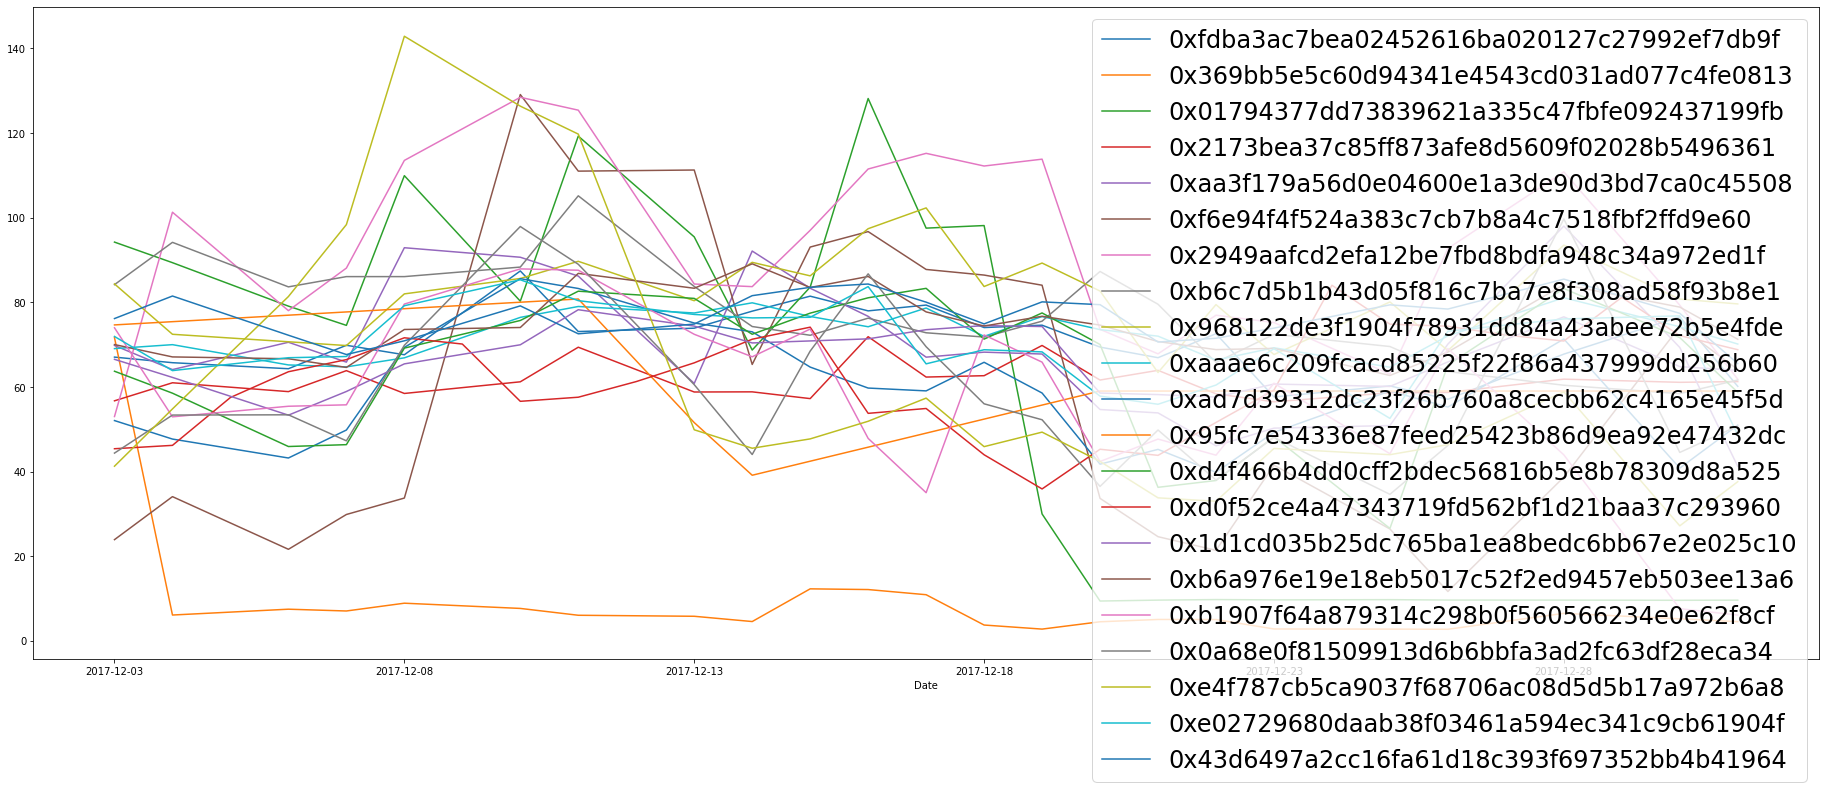

In [11]:
df.plot('Date' , figsize=(32 , 12)).legend(loc='best', fontsize=24)

In [12]:
# Hierarchy defintion
rows_list = df.drop("Date", axis=1).columns.tolist()

lHierarchy = {};
lHierarchy['Levels'] = ["Energy"];
lHierarchy['Data'] = pd.DataFrame(rows_list, columns =  ["Energy"]);
lHierarchy['Type'] = "Hierarchical";
lHierarchy

{'Levels': ['Energy'],
 'Data':                                         Energy
 0   0xfdba3ac7bea02452616ba020127c27992ef7db9f
 1   0x369bb5e5c60d94341e4543cd031ad077c4fe0813
 2   0x01794377dd73839621a335c47fbfe092437199fb
 3   0x2173bea37c85ff873afe8d5609f02028b5496361
 4   0xaa3f179a56d0e04600e1a3de90d3bd7ca0c45508
 5   0xf6e94f4f524a383c7cb7b8a4c7518fbf2ffd9e60
 6   0x2949aafcd2efa12be7fbd8bdfa948c34a972ed1f
 7   0xb6c7d5b1b43d05f816c7ba7e8f308ad58f93b8e1
 8   0x968122de3f1904f78931dd84a43abee72b5e4fde
 9   0xaaae6c209fcacd85225f22f86a437999dd256b60
 10  0xad7d39312dc23f26b760a8cecbb62c4165e45f5d
 11  0x95fc7e54336e87feed25423b86d9ea92e47432dc
 12  0xd4f466b4dd0cff2bdec56816b5e8b78309d8a525
 13  0xd0f52ce4a47343719fd562bf1d21baa37c293960
 14  0x1d1cd035b25dc765ba1ea8bedc6bb67e2e025c10
 15  0xb6a976e19e18eb5017c52f2ed9457eb503ee13a6
 16  0xb1907f64a879314c298b0f560566234e0e62f8cf
 17  0x0a68e0f81509913d6b6bbfa3ad2fc63df28eca34
 18  0xe4f787cb5ca9037f68706ac08d5d5b17a972b6a8
 19  0xe0